Download data and Import Libraries

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import shap
from sklearn.utils import resample

In [22]:
transformation_names = [
    "Original",            # No transformation
    "PowerTransformer",    # Uses PowerTransformer (Yeo-Johnson)
    "Log1p",               # log(x+1) transformation
    "Sqrt",                # Square root transformation
    "BoxCox",              # Box-Cox transformation (with shifting if necessary)
    "QuantileTransformer", # Maps data to a normal distribution
    "Normalization" 
]

In [23]:
# Directory containing the CSV files
directory = './split_data'

# Dictionary to store DataFrames
dataframes = {}

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Read the CSV file into a DataFrame
        df_name = filename.split('.')[0]  # Use the filename (without extension) as the key
        dataframes[df_name] = pd.read_csv(os.path.join(directory, filename))

# Display the keys of the dictionary to confirm
print(dataframes.keys())

dict_keys(['X_test_Sqrt', 'y_train', 'y_test', 'X_train_Normalization', 'data', 'X_test_Normalization', 'X_test_BoxCox', 'X_train_Original', 'X_test_PowerTransformer', 'X_train_Log1p', 'X_test_Original', 'X_train_Sqrt', 'X_train_BoxCox', 'X_train_PowerTransformer', 'X_test_Log1p', 'X_test_QuantileTransformer', 'X_train_QuantileTransformer'])


In [24]:
binary_cols = []
continuous_cols = []
categorical_cols = []

X_train = dataframes['X_train_Normalization']

for col in X_train.columns:
    unique_values = X_train[col].nunique()
    if unique_values == 2:
        binary_cols.append(col)
    elif X_train[col].dtype in ['float64', 'int64'] and unique_values > 10:
        continuous_cols.append(col)
    else:
        categorical_cols.append(col)

print("Binary Columns:", binary_cols)
print("Continuous Columns:", continuous_cols)
print("Categorical Columns:", categorical_cols)

Binary Columns: ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']
Continuous Columns: ['BMI', 'MentHlth', 'PhysHlth', 'Age']
Categorical Columns: ['GenHlth', 'Education', 'Income']


In [25]:
column = X_train.columns
column

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

Original


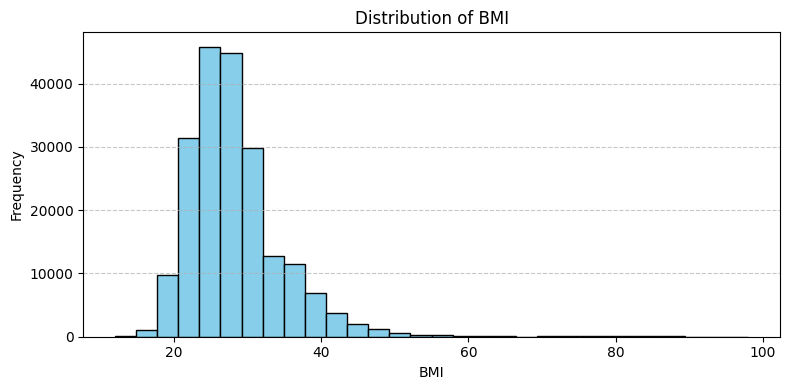

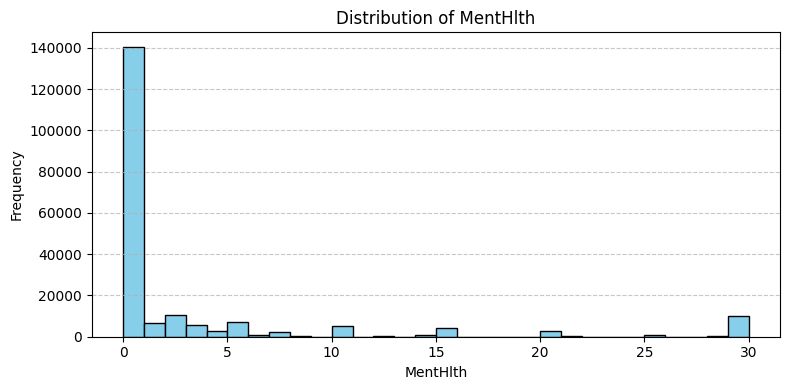

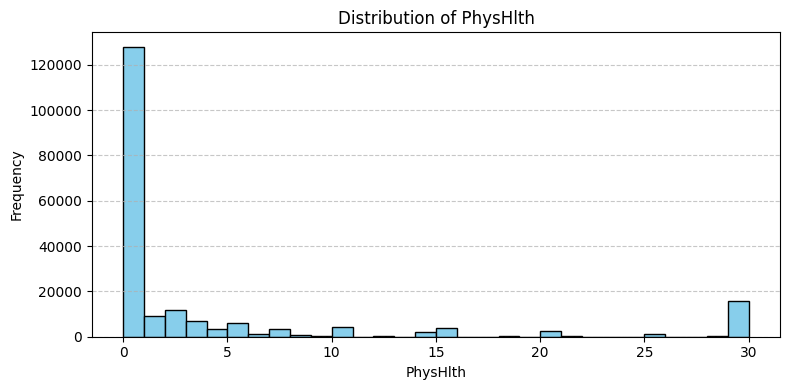

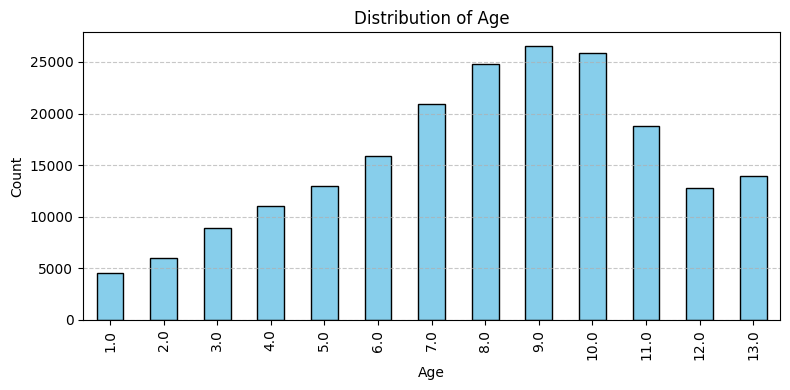

PowerTransformer


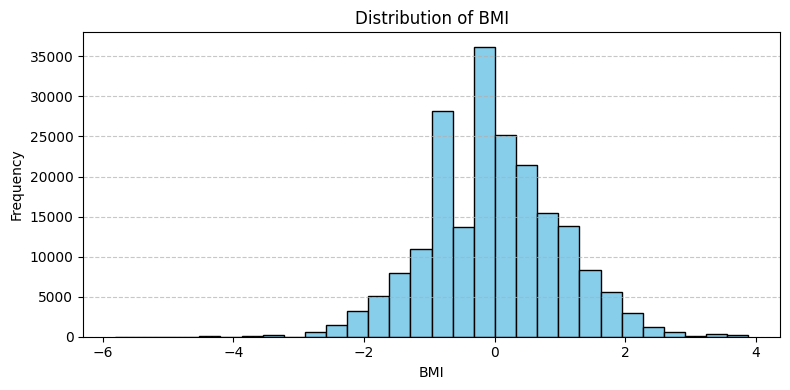

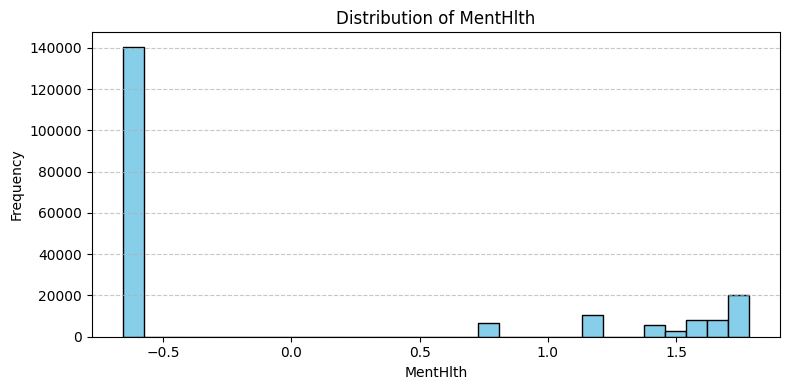

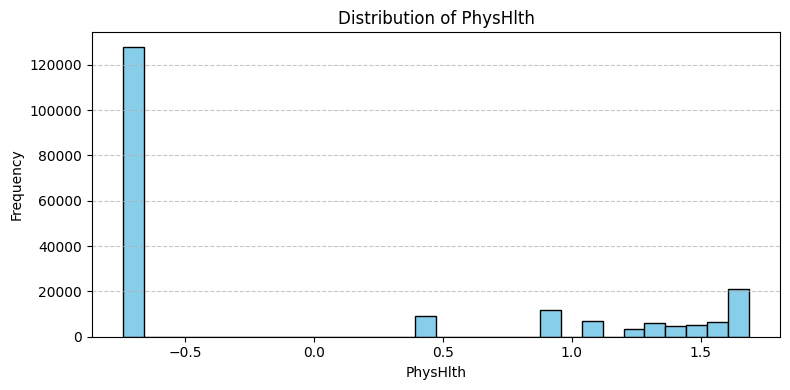

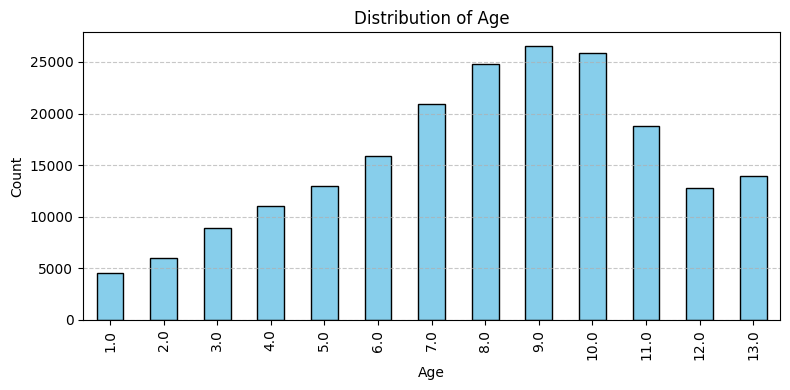

Log1p


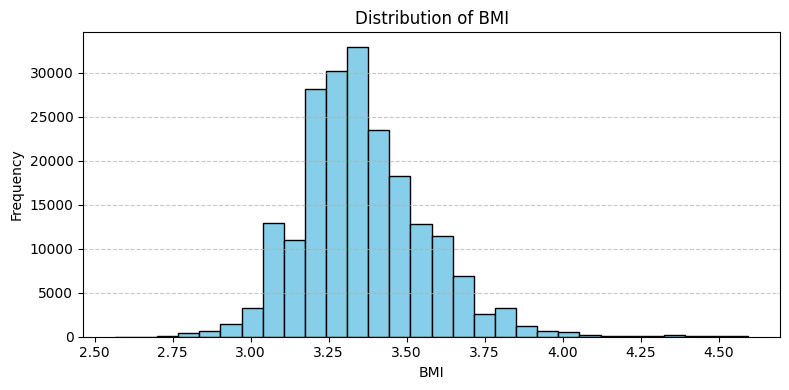

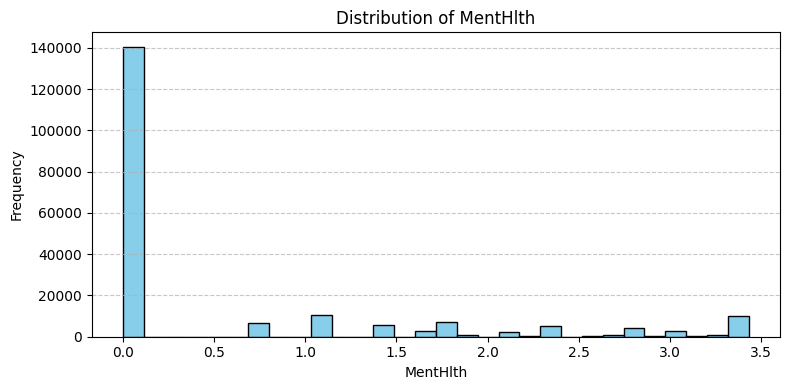

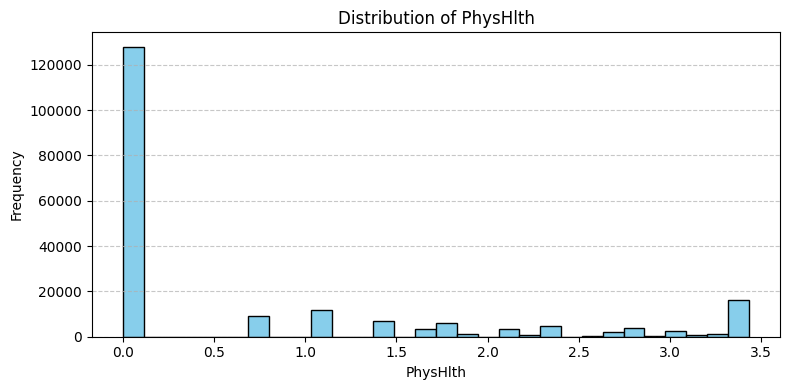

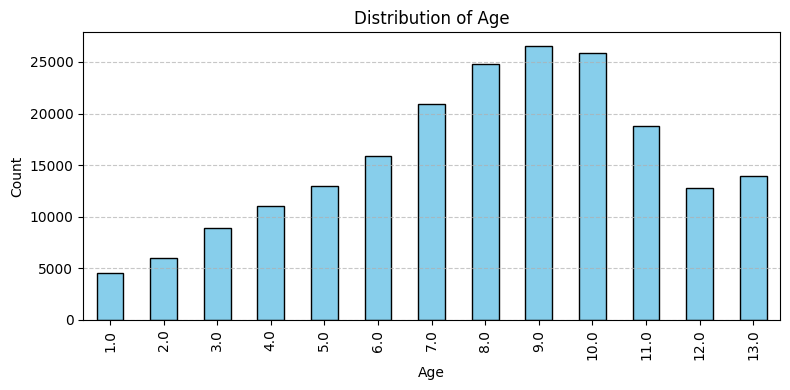

Sqrt


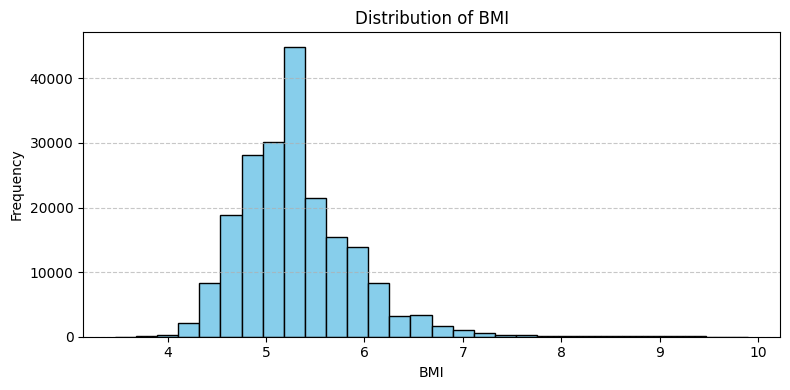

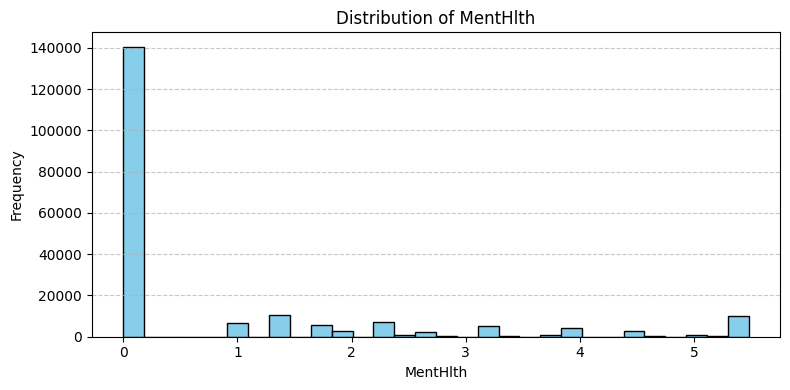

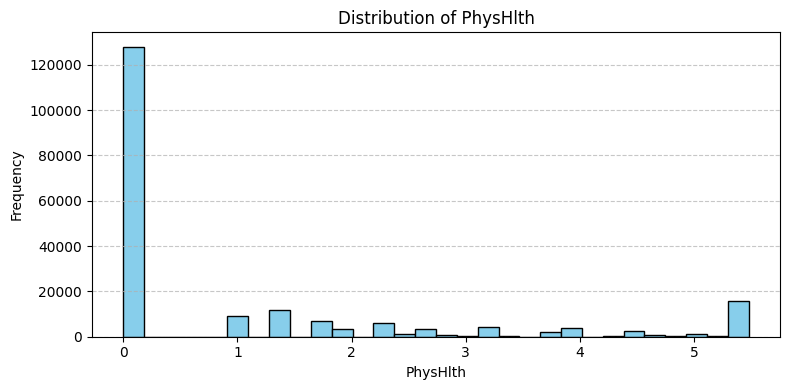

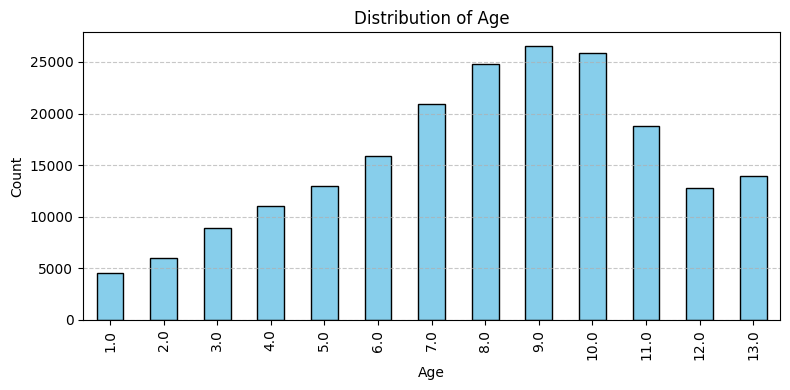

BoxCox


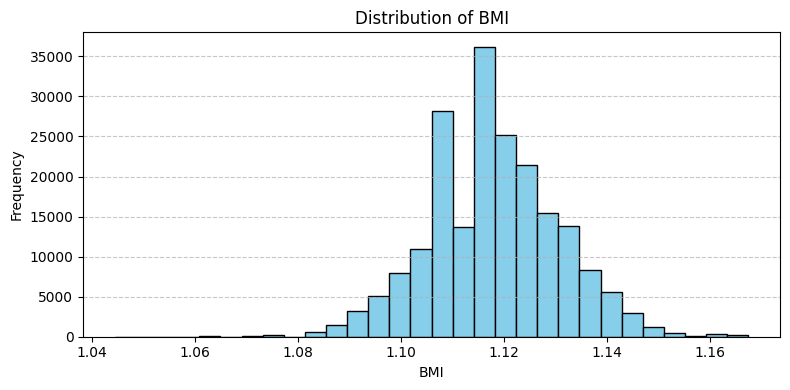

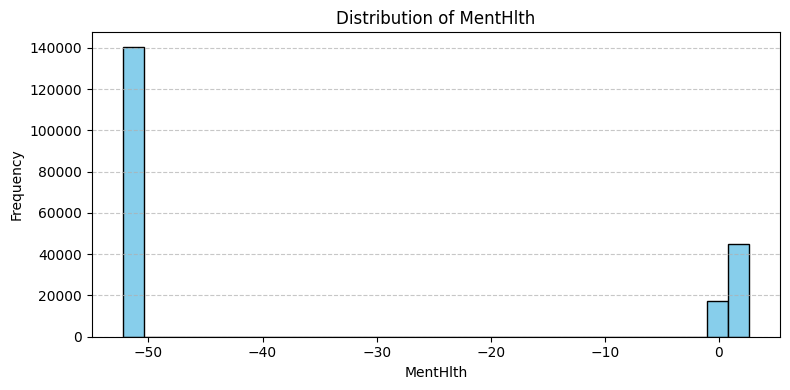

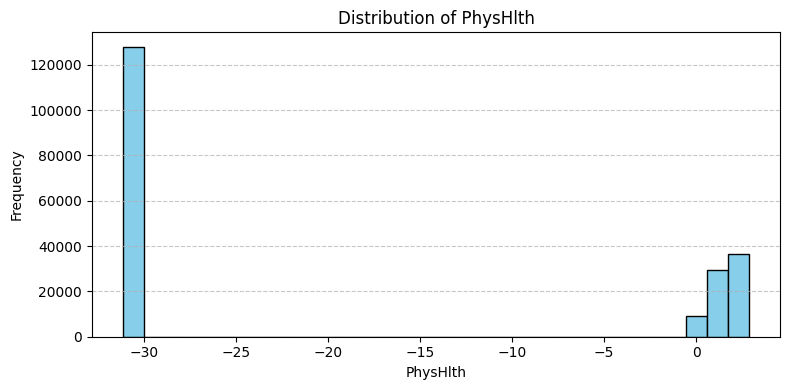

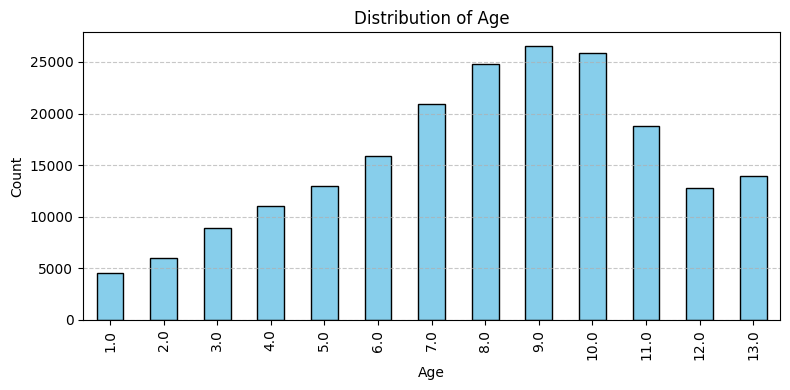

QuantileTransformer


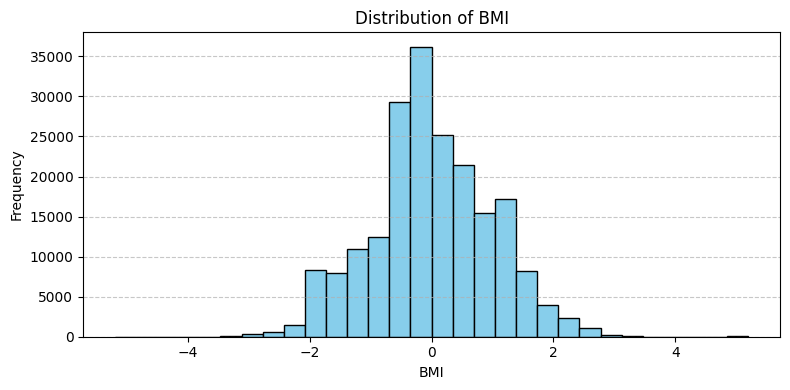

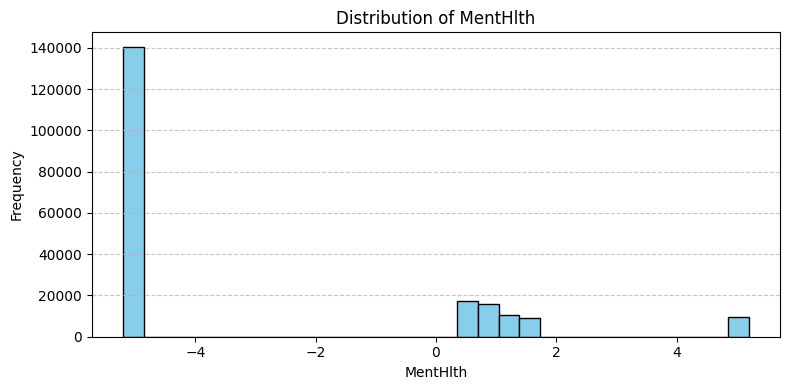

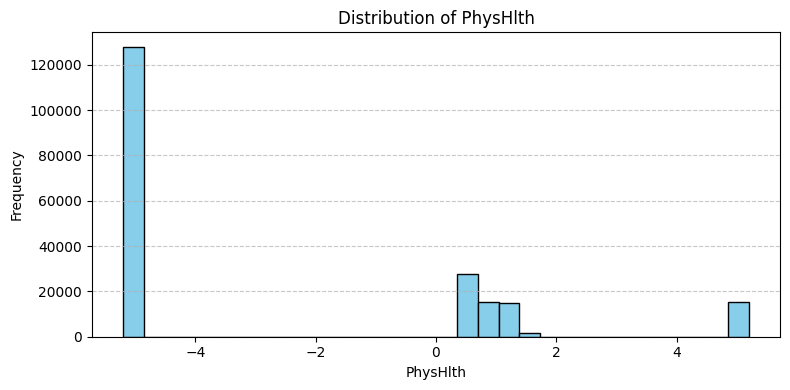

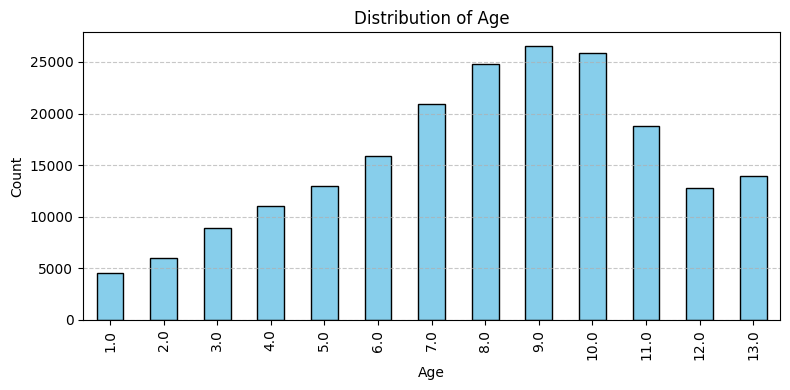

Normalization


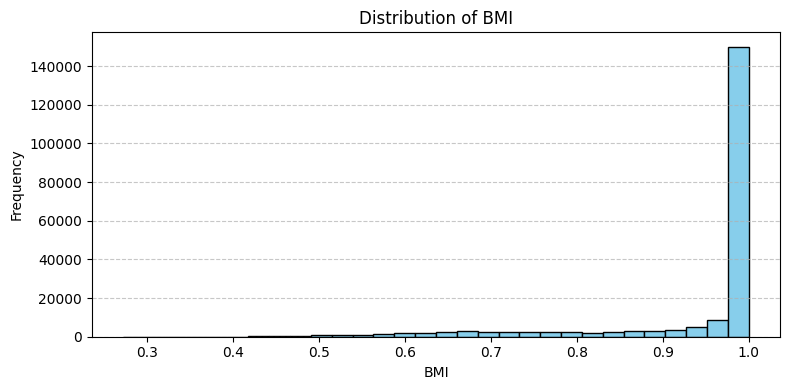

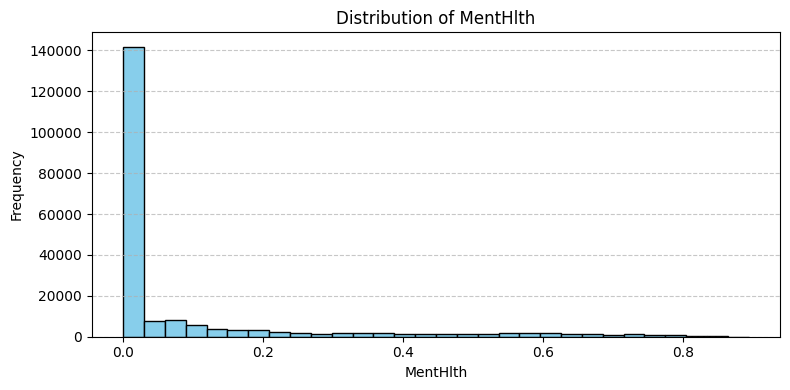

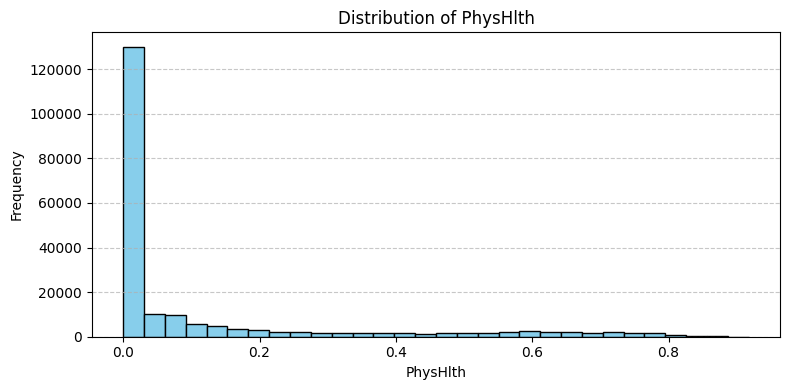

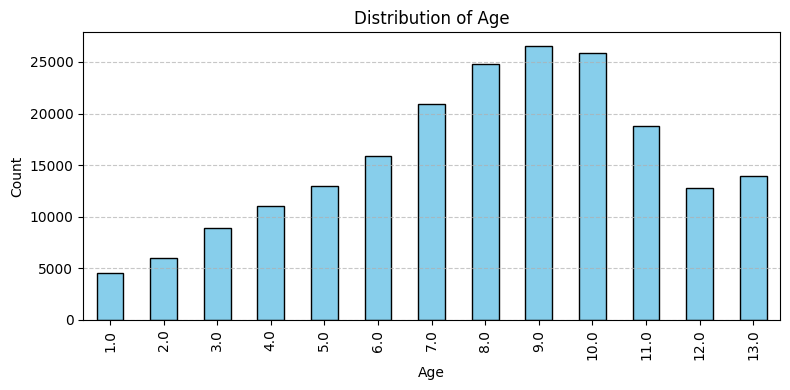

In [26]:
# Import necessary libraries
import matplotlib.pyplot as plt

features_to_visualize = ['BMI', 'MentHlth', 'PhysHlth', 'Age']

for _ in transformation_names:

    print(_)
    name = 'X_train_' + _
    X = dataframes[name]

    # Iterate through each column in X
    for col in features_to_visualize:
        plt.figure(figsize=(8, 4))
        if X[col].nunique() < 20:  # For categorical or low-cardinality features
            X[col].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
            plt.title(f'Distribution of {col}')
            plt.xlabel(col)
            plt.ylabel('Count')
        else:  # For continuous features
            X[col].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
            plt.title(f'Distribution of {col}')
            plt.xlabel(col)
            plt.ylabel('Frequency')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show() 

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

continuous_cols = ['BMI', 'MentHlth', 'PhysHlth', 'Age']
categorical_cols = [col for col in column if col not in continuous_cols]

# Custom implementation of Naive Bayes
# Use Gaussian distribution to predict continuous variables
# Use categorical distribution to predict discrete variables
# Combine probabilities for final prediction
class MixedNaiveBayes:
    def __init__(self, continuous_cols, categorical_cols, priors=None):
        self.continuous_cols = continuous_cols
        self.categorical_cols = categorical_cols
        self.priors = priors
        if self.priors is not None:  # If class prior is provided
            self.gaussian_nb = GaussianNB(priors=self.priors)
            self.categorical_nb = CategoricalNB(fit_prior=False, class_prior=self.priors)
        else:
            self.gaussian_nb = GaussianNB()
            self.categorical_nb = CategoricalNB()
        self.has_categorical = len(categorical_cols) > 0

    def fit(self, X, y):
        # Split continuous and categorical data
        X_continuous = X[self.continuous_cols]
        if self.has_categorical:
            X_categorical = X[self.categorical_cols]
        
        # Fit GaussianNB for continuous data
        self.gaussian_nb.fit(X_continuous, y)
        
        if self.has_categorical:
            # Fit CategoricalNB for categorical data
            self.categorical_nb.fit(X_categorical, y)

    def predict(self, X):
        # Split continuous and categorical data
        X_continuous = X[self.continuous_cols]
        if self.has_categorical:
            X_categorical = X[self.categorical_cols]
        
        # Predict log probabilities for continuous and categorical data
        log_prob_continuous = self.gaussian_nb.predict_log_proba(X_continuous)
        log_prob_categorical = np.zeros_like(log_prob_continuous)
        if self.has_categorical:
            log_prob_categorical = self.categorical_nb.predict_log_proba(X_categorical)
        
        # Combine log probabilities and predict the class with maximum sum
        combined_log_prob = log_prob_continuous + log_prob_categorical
        return combined_log_prob.argmax(axis=1)

    def predict_proba(self, X):
        # Split continuous and categorical data
        X_continuous = X[self.continuous_cols]
        if self.has_categorical:
            X_categorical = X[self.categorical_cols]
        
        # Predict probabilities for continuous and categorical data
        prob_continuous = self.gaussian_nb.predict_proba(X_continuous)
        if self.has_categorical:
            prob_categorical = self.categorical_nb.predict_proba(X_categorical)
            combined_prob = prob_continuous * prob_categorical
        else:
            combined_prob = prob_continuous
        return combined_prob

models = {
    "knn": KNeighborsClassifier(
        n_neighbors=5
    ),
    "GauNB": GaussianNB(),
    "MixNB": MixedNaiveBayes(
        continuous_cols=continuous_cols, 
        categorical_cols=categorical_cols
    ),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "xgboost": XGBClassifier()
}

In [30]:
y_train, y_test = dataframes['y_train'].squeeze(), dataframes['y_test'].squeeze()

# Boolean variables to control pipeline
TRAINING_DATA_UNDERSAMPLING = True
BALANCE_TEST_DATA = True 
STAND_FEATURES = True

epochs = 1

# Logging
if TRAINING_DATA_UNDERSAMPLING:
    print("Majority class undersampling applied.\n")
if BALANCE_TEST_DATA:
    print("Balancing test dataset applied.\n")
if STAND_FEATURES:
    print("Standardized features applied.\n")

for epoch in range(epochs):

    best_results = []

    for name, model in models.items():
        best_transformation = None
        best_metrics = None
        best_f1_score = -np.inf

        for _ in transformation_names:
            X_train_name = 'X_train_' + _
            X_test_name = 'X_test_' + _
            X_train, X_test = dataframes[X_train_name], dataframes[X_test_name]

            # Under sampling training data
            if TRAINING_DATA_UNDERSAMPLING:
                # Combine X_train and y_train for resampling
                X_train['target'] = y_train
                class_0 = X_train[y_train == 0]
                class_1 = X_train[y_train == 1]

                # Undersample class 0
                class_0_undersampled = resample(class_0, 
                                                replace=False, 
                                                n_samples=len(class_1), 
                                                random_state=69)

                # Combine undersampled class 0 and class 1
                X_train_balanced = pd.concat([class_0_undersampled, class_1])
                y_train_balanced = X_train_balanced['target']
                X_train_balanced = X_train_balanced.drop(columns=['target'])
            else:
                # Use the original training data without undersampling
                X_train_balanced = X_train
                y_train_balanced = y_train

            # Balancing test data
            if BALANCE_TEST_DATA:
                X_test['target'] = y_test
                class_0_test = X_test[y_test == 0]
                class_1_test = X_test[y_test == 1]

                # Undersample class 0 in the test data
                class_0_test_undersampled = resample(class_0_test, 
                                                    replace=False, 
                                                    n_samples=len(class_1_test), 
                                                    random_state=69)

                # Combine undersampled class 0 and class 1 in the test data
                X_test_balanced = pd.concat([class_0_test_undersampled, class_1_test])
                y_test_balanced = X_test_balanced['target']

                # Drop target column
                X_test_balanced = X_test_balanced.drop(columns=['target'])
            else:
                # Use the original test data without balancing
                X_test_balanced = X_test
                y_test_balanced = y_test

            # Feature standardization
            if STAND_FEATURES:
                scaler = StandardScaler()
                scaler.fit_transform(X_train_balanced)
                scaler.transform(X_test_balanced)

            # Use CV for choose knn k
            if name == "knn":
                knn_param_grid = {
                    'n_neighbors': [5, 50, 100]
                }
                knn_grid_search = GridSearchCV(
                    estimator=model,
                    param_grid=knn_param_grid,
                    scoring='f1', # evaluation metric
                    cv=5,
                    n_jobs=-1
                )

                knn_grid_search.fit(X_train_balanced, y_train_balanced)
                best_k = knn_grid_search.best_params_['n_neighbors']
                model = KNeighborsClassifier(n_neighbors=best_k)

            print(f"{_}: Best k for KNN: {best_k}")
            
            # Train and evaluate the model
            model.fit(X_train_balanced, y_train_balanced)
            y_pred = model.predict(X_test_balanced)
            y_prob = model.predict_proba(X_test_balanced)[:, -1]

            # Calculate metrics
            metrics = {
                "Transformation": _,
                "Accuracy": accuracy_score(y_test_balanced, y_pred), # accuracy is not useful since dataset is imbalanced
                "Precision": precision_score(y_test_balanced, y_pred),
                "Recall": recall_score(y_test_balanced, y_pred),
                "F1 Score": f1_score(y_test_balanced, y_pred),
                "ROC AUC": roc_auc_score(y_test_balanced, y_prob)
            }

            # Check if this transformation is the best for the current model based on F1 Score
            if metrics["F1 Score"] > best_f1_score:
                best_f1_score = metrics["F1 Score"]
                best_transformation = _
                best_metrics = metrics

        # Save the best transformation and metrics for the current model
        best_results.append({
            "Model": name,
            **best_metrics
        })

    # Convert the best results to a DataFrame and display
    best_results_df = pd.DataFrame(best_results)
    print("\nBest Transformation Results for Each Model:")
    print(best_results_df)

    print(f'Completed epoch {epoch+1}/{epochs}\n')

Majority class undersampling applied.

Balancing test dataset applied.

Standardized features applied.

Original: Best k for KNN: 100
PowerTransformer: Best k for KNN: 100
Log1p: Best k for KNN: 100
Sqrt: Best k for KNN: 100
BoxCox: Best k for KNN: 100
QuantileTransformer: Best k for KNN: 100
Normalization: Best k for KNN: 100
Original: Best k for KNN: 100
PowerTransformer: Best k for KNN: 100
Log1p: Best k for KNN: 100
Sqrt: Best k for KNN: 100
BoxCox: Best k for KNN: 100
QuantileTransformer: Best k for KNN: 100
Normalization: Best k for KNN: 100
Original: Best k for KNN: 100
PowerTransformer: Best k for KNN: 100
Log1p: Best k for KNN: 100
Sqrt: Best k for KNN: 100
BoxCox: Best k for KNN: 100
QuantileTransformer: Best k for KNN: 100
Normalization: Best k for KNN: 100
Original: Best k for KNN: 100
PowerTransformer: Best k for KNN: 100
Log1p: Best k for KNN: 100
Sqrt: Best k for KNN: 100
BoxCox: Best k for KNN: 100
QuantileTransformer: Best k for KNN: 100
Normalization: Best k for KNN: 